# Predicting Gold Prices with a Long Short-Term Memory (LSTM) Model

This notebook will look at how gold prices can be forecasted using a recurrent neural network algorithm such as `LSTM`. The deep learning model uses historical gold prices for 3 currencies: `USD`, `GBP` and `EUR`. Time series data spanning 22 years has been obtained and the goal is to compare the prediction prices against the actual data to see how close the model can predict the movement of gold prices.

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

## Data Import
As part of this exercise, historical gold prices from the London Bullion Market Association are downloaded using the Quandl API. The API can be accessed @ ["Gold Price: LBMA"](https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing) and the data can be downloaded in csv, json or xml format. 

In [2]:
gold_data = pd.read_csv("/Users/user/Desktop/CF969/LBMA-GOLD.csv")
gold_data.head()

,Date,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
0,2021-04-22,1785.65,1787.75,1285.31,1291.11,1484.05,1486.34
1,2021-04-21,1781.05,1798.20,1278.97,1292.91,1482.72,1497.18
2,2021-04-20,1765.50,1777.85,1262.16,1274.19,1464.13,1476.33
3,2021-04-19,1788.40,1774.50,1288.01,1271.07,1486.88,1475.50
4,2021-04-16,1766.45,1774.45,1283.68,1286.30,1475.16,1481.13


In [3]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13474 entries, 0 to 13473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       13474 non-null  object 
 1   USD (AM)   13473 non-null  float64
 2   USD (PM)   13331 non-null  float64
 3   GBP (AM)   13463 non-null  float64
 4   GBP (PM)   13320 non-null  float64
 5   EURO (AM)  5637 non-null   float64
 6   EURO (PM)  5594 non-null   float64
dtypes: float64(6), object(1)
memory usage: 737.0+ KB


In [4]:
#Identify missing values
gold_data.isnull().sum()

Date            0
USD (AM)        1
USD (PM)      143
GBP (AM)       11
GBP (PM)      154
EURO (AM)    7837
EURO (PM)    7880
dtype: int64

The file contains daily data from 1968 until 22nd April 2021. However, the Euro was first introduced on 1st January 1999. In order to prevent any kind of bias, the dataset has been reduced to the last 22 years only (1st January 1999 until 22nd April 2021). For the purpose of this notebook, the column `USD (AM)` is used to predict the prices of gold. The columns `GBP (AM)` and `EURO (AM)` can also be used to predict the price of gold and the changes required to do so are explained in the `Data Preprocessing` section.

In [5]:
#Format the 'Date' column to datetime format
gold_data['Date'] = pd.to_datetime(gold_data['Date'], infer_datetime_format = True)

#Filter for data items from when the Euro was introduced, onwards.
gold_df = gold_data.loc[(gold_data['Date'] >= '1999-01-01')]

#Set the "Date" column as the Dataframe Index
gold_df.set_index('Date', inplace = True)

#Fill missing values with the previous ones
gold_df.fillna(method = 'ffill')

#Sort dataframe in ascending order based on the date index
gold_df = gold_df.sort_index(ascending=True)
gold_df.head()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
1999-01-04,288.25,287.15,173.854,172.930,244.383,243.039
1999-01-05,287.00,287.15,173.362,172.947,242.809,242.918
1999-01-06,287.15,287.65,173.191,173.733,244.258,245.331
1999-01-07,288.60,289.95,174.486,175.887,247.089,248.351
1999-01-08,290.90,290.90,177.000,177.324,249.293,250.992


## Data Exploration 

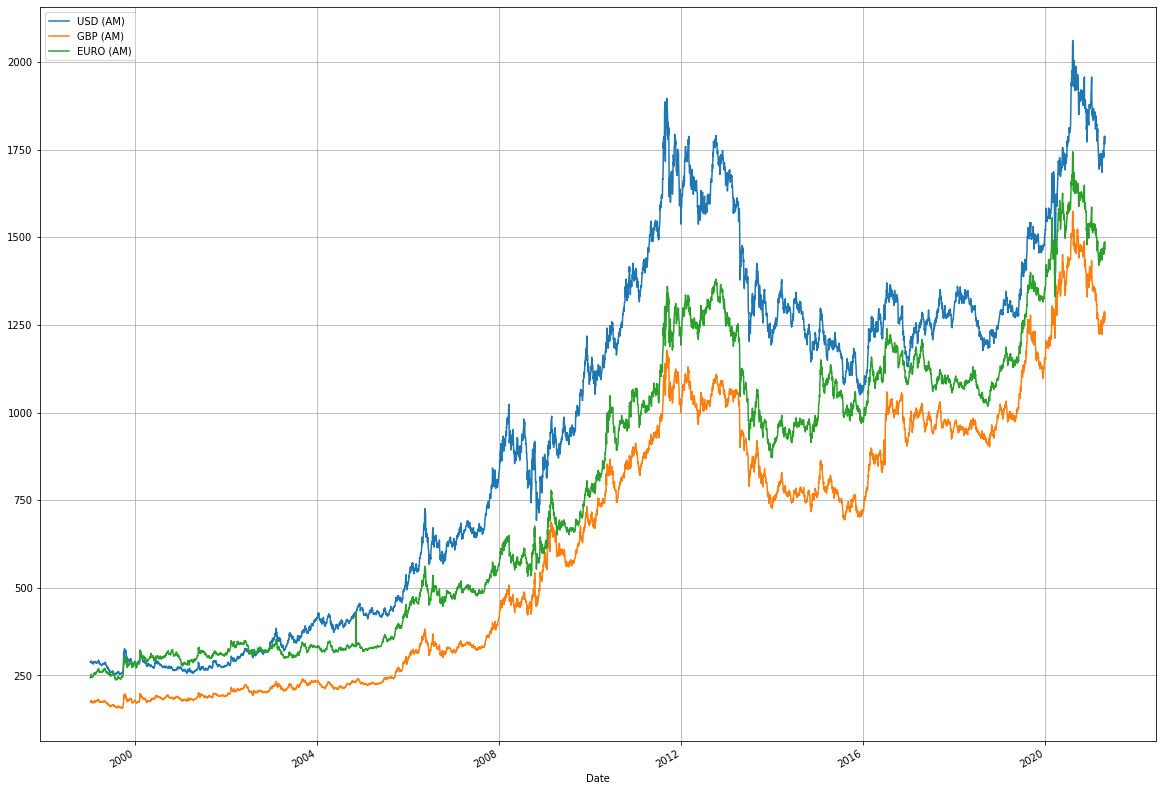

In [6]:
plot_frame = pd.DataFrame()

plot_frame = pd.concat([gold_df['USD (AM)'],
  gold_df['GBP (AM)'],
  gold_df['EURO (AM)']], axis=1)
plot_frame.plot(figsize=(20, 15), grid=True)

The plot above shows the movement in gold prices across all 3 currencies for the last 22 years. The structure isn't uniformly visible for the three currencies. As a result, it is more appropriate to divide the individual price by the maximum value for that currency, and then replot. The maximum value of all prices will then be 1.

In [7]:
gold_df['USD_Open_Scaled'] = gold_df['USD (AM)'] / max(gold_df['USD (AM)'])
gold_df['GBP_Open_Scaled'] = gold_df['GBP (AM)'] / max(gold_df['GBP (AM)'])
gold_df['EURO_Open_Scaled'] = gold_df['EURO (AM)'] / max(gold_df['EURO (AM)'])
gold_df.head()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM),USD_Open_Scaled,GBP_Open_Scaled,EURO_Open_Scaled
Date,,,,,,,,,
1999-01-04,288.25,287.15,173.854,172.930,244.383,243.039,0.139825,0.110428,0.140142
1999-01-05,287.00,287.15,173.362,172.947,242.809,242.918,0.139219,0.110115,0.139240
1999-01-06,287.15,287.65,173.191,173.733,244.258,245.331,0.139292,0.110007,0.140071
1999-01-07,288.60,289.95,174.486,175.887,247.089,248.351,0.139995,0.110829,0.141694
1999-01-08,290.90,290.90,177.000,177.324,249.293,250.992,0.141111,0.112426,0.142958


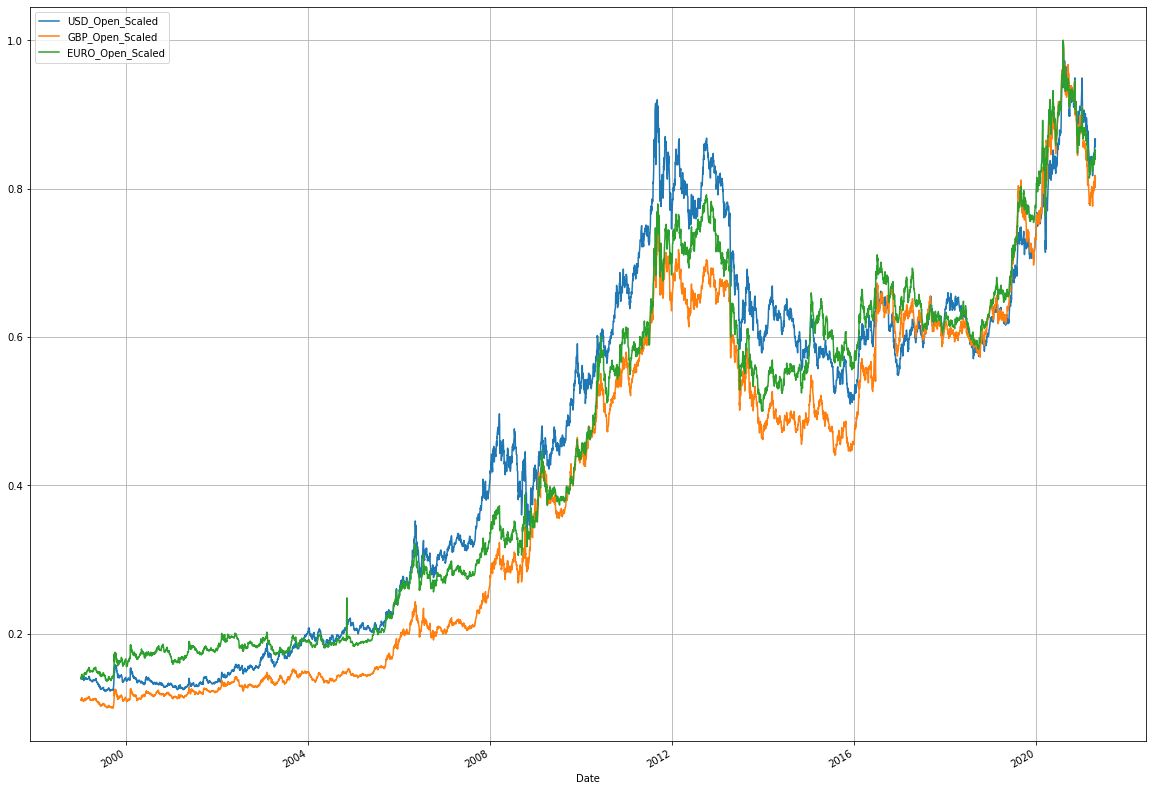

In [8]:
_ = pd.concat([gold_df['USD_Open_Scaled'],
  gold_df['GBP_Open_Scaled'],
  gold_df['EURO_Open_Scaled']], axis=1).plot(figsize=(20, 15), grid=True)

Across the 22 year period, the prices are correlated. Sudden variations in price caused by systemic risk affected the valuation of gold across all 3 currencies, and they otherwise exhibited general rises. Gold is seen as a safe haven in times of economic or social turmoil and this can be observed in 2020 when gold prices rose as a result of the COVID 19 pandemic.

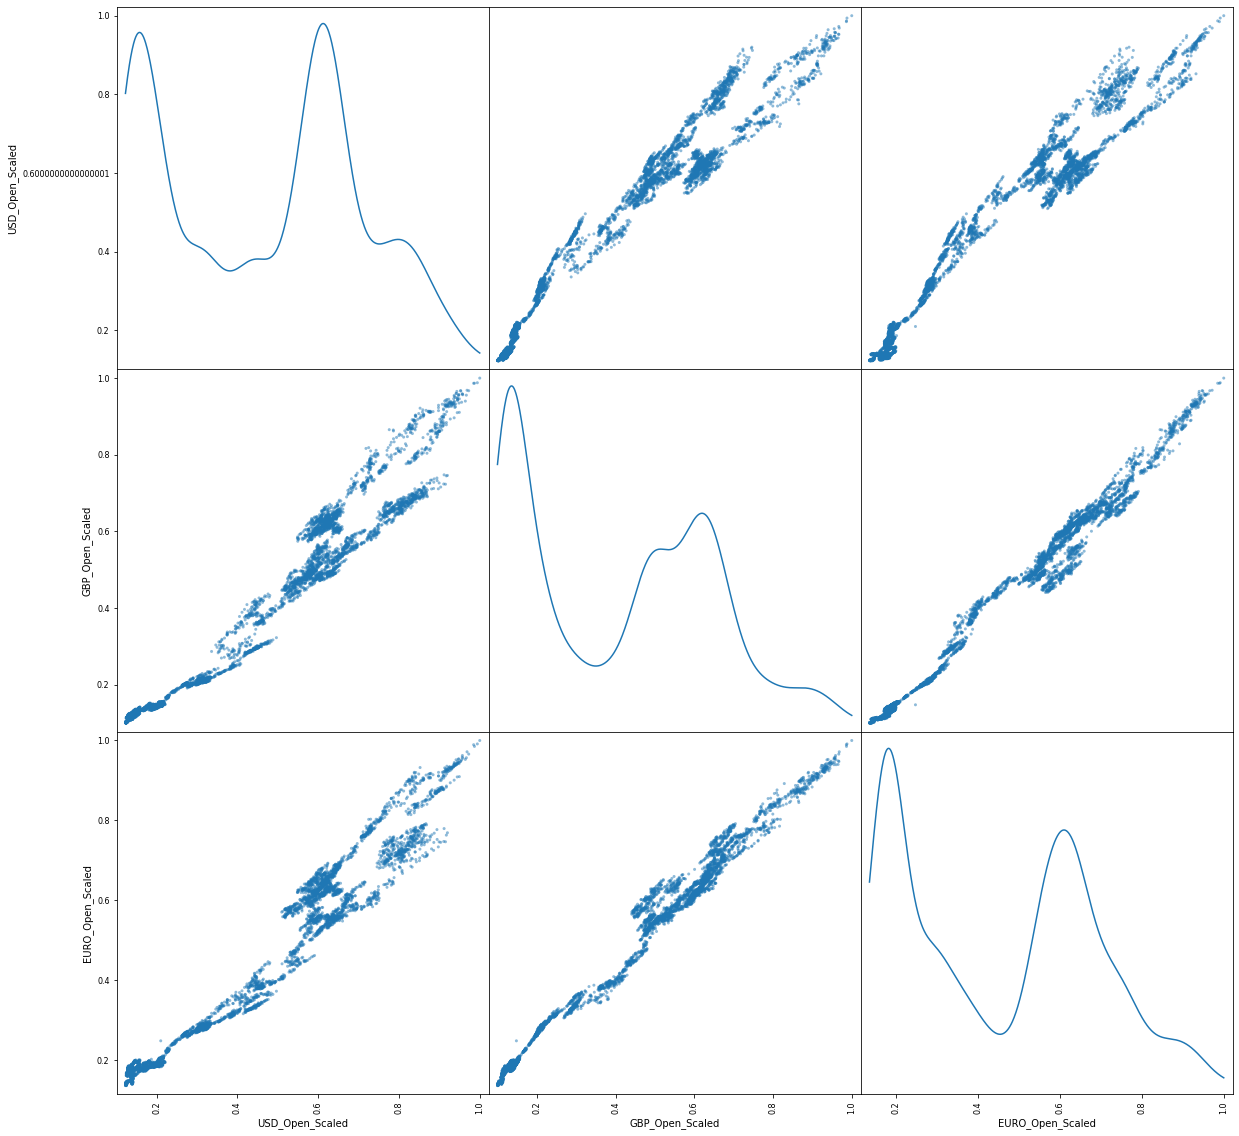

In [9]:
plot_frame=pd.concat([gold_df['USD_Open_Scaled'],
  gold_df['GBP_Open_Scaled'],
  gold_df['EURO_Open_Scaled']], axis=1)
_ = scatter_matrix(plot_frame, figsize=(20, 20), diagonal='kde')

The scatter matrix above shows everything plotted against everything, to see how prices are correlated with each other. 

##  Data Preprocessing
The window size for the data is defined as 30 days. Every term is represented as a function of the previous n terms: `Y(t+1) = f(x(t),x(t-1),x(t-2)...x(t-n-1)`. This ends up creating arrays containing values split into 30 day intervals that will be used to predict the next value.

In [10]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

#The function returns two numpy arrays of X and y.

In [11]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns to 0 for USD, 2 for GBP and 4 for EUR. Default is 0
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(gold_df, window_size, feature_column, target_column)

Time-series anlayses are sensitive to the order of the data. As such, the `train_test_split` function is not used, as it would randomise the sample. A more appropriate approach is to manually split the data set by slicing the array. The split is 75% for train data and 25% for test data.

In [12]:
# Split the data between Train and Test
split = int(0.75*len(X))
X_train = X[:split - 1]
X_test = X[split:]
y_train = y[:split - 1]
y_test = y[split:]

In [13]:
# Create a MinMaxScaler object which will scale the dataset between 0 and 1.
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [14]:
# Reshape the features data, as the Keras LSTM model requires the input data to come as a vertical vector.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Model Development

In [15]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30 #number of units per layer, similar to the number of windows
dropout_fraction = 0.2 #20% of neurons will be dropped at random on each epoch

#The LSTM model will have 3 layers and there will be a dropout after each one.
# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [16]:
#Compile the model
#The model is compiled using an adam optimiser, the mean square error is used as a loss function and 
#the mean aboslute error is used as a performance metric
model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])

In [17]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [18]:
# Train the model using 20 epochs and a batch size of 90. Shuffle is set to "False" 
# as the data used is a time-series and the sequence must be preserved
model.fit(X_train, y_train, epochs=20, batch_size=90, shuffle=False, verbose=1)

Epoch 1/20
47/47 [==============================] - 5s 25ms/step - loss: 0.0016 - mae: 0.0244
Epoch 2/20
47/47 [==============================] - 1s 23ms/step - loss: 0.0241 - mae: 0.1356
Epoch 3/20
47/47 [==============================] - 1s 21ms/step - loss: 0.0236 - mae: 0.1359
Epoch 4/20
47/47 [==============================] - 1s 20ms/step - loss: 0.0214 - mae: 0.1257
Epoch 5/20
47/47 [==============================] - 1s 19ms/step - loss: 0.0178 - mae: 0.1139
Epoch 6/20
47/47 [==============================] - 1s 19ms/step - loss: 0.0113 - mae: 0.0820
Epoch 7/20
47/47 [==============================] - 1s 19ms/step - loss: 0.0273 - mae: 0.1296
Epoch 8/20
47/47 [==============================] - 1s 19ms/step - loss: 0.0060 - mae: 0.0645
Epoch 9/20
47/47 [==============================] - 1s 19ms/step - loss: 0.0074 - mae: 0.0652
Epoch 10/20
47/47 [==============================] - 1s 19ms/step - loss: 0.0038 - mae: 0.0514
Epoch 11/20
47/47 [==============================] - 1s 20m

# Model Evaluation
The steps for evaluating the model are as follows:
1. Evaluate the model using the `X_test` and `y_test` data
2. Make the relevant predictions
3. Create a dataframe of actual and predicted values
4. Plot the actual and predicted values

In [19]:
# Evaluate the model
print(model.metrics_names)
print(model.evaluate(X_test, y_test, verbose=0))

['loss', 'mae']
[0.0029981948900967836, 0.04964613914489746]


In [20]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [21]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [22]:
# Create a dataframe of actual and predicted values
test_index = gold_df.index[-len(real_prices):]
gold = pd.DataFrame({
        "Actual": real_prices.ravel(), "Predicted": predicted_prices.ravel()
}, index=test_index)

# Show the dataframe's most recent values 
gold.tail() #.tail() is used as the dataframe is sorted in ascending order

,Actual,Predicted
Date,,
2021-04-16,1748.00,1657.459717
2021-04-19,1766.45,1658.411743
2021-04-20,1788.40,1659.654297
2021-04-21,1765.50,1661.433716
2021-04-22,1781.05,1663.425903


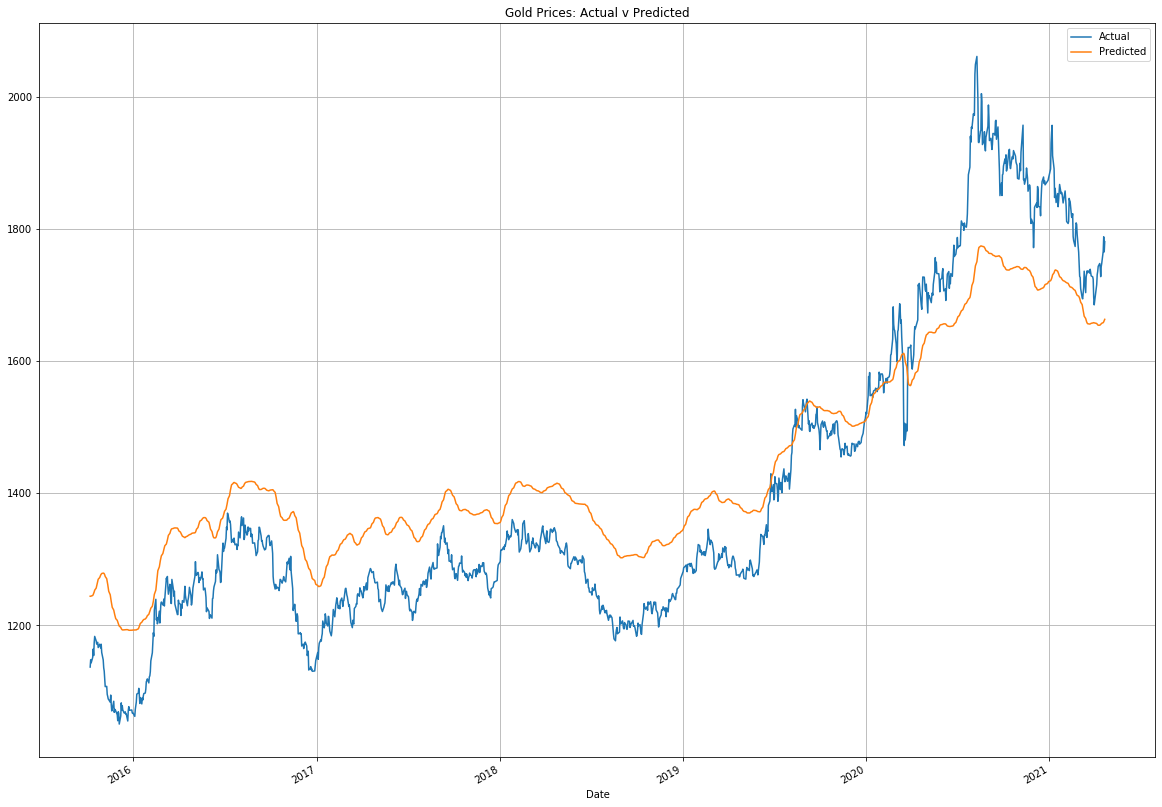

In [23]:
#Assess the prediction by plotting the real prices against the predicted prices
gold.plot(figsize=(20, 15), grid=True,title="Gold Prices: Actual v Predicted")

# Conclusion
The model was trained using data from 1999 until 2016 and tested with the actual prices from 2016 until April 2021. The model predicted the trend with reasonable accuracy, even though there is a gap between the actual and predicted prices. Until the Covid 19 pandemic started in early 2020, the predicted values were larger than the actual values; however, it can be observed that the actual spike in price is higher than the predicted values once the pandemic started.